In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('../names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])

torch.Size([182448, 3]) torch.Size([182448])
torch.Size([22762, 3]) torch.Size([22762])
torch.Size([22936, 3]) torch.Size([22936])


In [5]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10
n_hidden = 64

C  = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3)/((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden) * 0.1

W2 = torch.randn((n_hidden, vocab_size)) * 0.1
b2 = torch.randn(vocab_size) * 0.1

bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

4073


In [7]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

In [13]:
emb =  C[Xb]
embcat = emb.view(emb.shape[0], -1)
hprebn = embcat @ W1
bnmeani = 1/n*hprebn.sum(0,keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
h = torch.tanh(hpreact)
logits = h @ W2 + b2
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1,keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[(range(n), Yb)].mean()

for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3740, grad_fn=<NegBackward0>)

In [36]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[(range(n), Yb)] = -1.0/n
cmp('logprobs', dlogprobs, logprobs)
dprobs = dlogprobs/(probs)
cmp('probs', dprobs, probs)
dcount_sum_inv = (dprobs*counts).sum(1, keepdim=True)
cmp('counts_sum_inv', dcount_sum_inv, counts_sum_inv)
# dcounts =  dprobs*counts_sum_inv
dcounts_sum = -dcount_sum_inv*((1/counts_sum)**2)
cmp('counts_sum', dcounts_sum, counts_sum)
dcounts =  dprobs*counts_sum_inv
dcounts+=dcounts_sum*torch.ones_like(counts)
cmp('counts', dcounts, counts)
dnorm_logits = counts*dcounts
cmp('norm_logits', dnorm_logits, norm_logits)
dlogit_maxes = (dnorm_logits*-1).sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)
dh = dlogits @ W2.T
cmp('h', dh, h)
dW2 = h.T @ dlogits
cmp('W2', dW2, W2)
db2 = dlogits.sum(0)
cmp('b2', db2, b2)
dhpreact = (1-h**2)*dh
cmp('hpreact',dhpreact,hpreact)
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
cmp('bngain',dbngain,bngain)
dbnraw = bngain * dhpreact
cmp('bnraw',dbnraw,bnraw)
dbnbias = dhpreact.sum(0, keepdim=True)
cmp('bnbias',dbnbias,bnbias)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('dbnvar_inv',dbnvar_inv,bnvar_inv)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('dbnvar',dbnvar,bnvar)
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
cmp('dbndiff2',dbndiff2,bndiff2)
dbndiff += (2*bndiff) * dbndiff2
cmp('dbndiff',dbndiff,bndiff)
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
cmp('dbnmeani',dbnmeani,bnmeani)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
cmp('dhprebn',dhprebn,hprebn)
dembcat = dhprebn @ W1.T
cmp('dembcat',dembcat,embcat)
dW1 = embcat.T @ dhprebn
cmp('dW1',dW1,W1)
demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
counts          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
norm_logits     | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
logit_maxes     | exact: False | approximate: True  | maxdiff: 4.889443516731262e-09
logits          | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09
h               | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
W2              | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
b2              | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
hpreact         | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bngain          | exact: False |

In [37]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.374014139175415 diff: -4.76837158203125e-07


In [38]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.3551048040390015e-09


In [39]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [40]:
F.softmax(logits, 1)[0]

tensor([0.0422, 0.0264, 0.0420, 0.0387, 0.0148, 0.0279, 0.0570, 0.0209, 0.0285,
        0.0652, 0.0373, 0.0383, 0.0209, 0.0398, 0.0246, 0.0163, 0.0547, 0.0295,
        0.0153, 0.0480, 0.1060, 0.0370, 0.0350, 0.0427, 0.0210, 0.0307, 0.0396],
       grad_fn=<SelectBackward0>)

In [41]:
dlogits[0] * n

tensor([ 0.0422, -0.9736,  0.0420,  0.0387,  0.0148,  0.0279,  0.0570,  0.0209,
         0.0285,  0.0652,  0.0373,  0.0383,  0.0209,  0.0398,  0.0246,  0.0163,
         0.0547,  0.0295,  0.0153,  0.0480,  0.1060,  0.0370,  0.0350,  0.0427,
         0.0210,  0.0307,  0.0396], grad_fn=<MulBackward0>)

In [42]:
dlogits[0].sum()

tensor(3.7253e-09, grad_fn=<SumBackward0>)

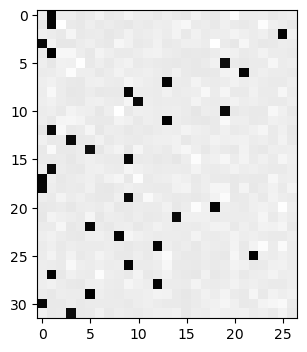

In [43]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [44]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [46]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


In [47]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [48]:
n_embd = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True
max_steps = 200000
batch_size = 32
n = batch_size
lossi = []
with torch.no_grad():
  for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hprebn = embcat @ W1 + b1
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    for p in parameters:
      p.grad = None
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    dhpreact = (1.0 - h**2) * dh
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    lr = 0.1 if i < 100000 else 0.01
    for p, grad in zip(parameters, grads):
      p.data += -lr * grad
    if i % 10000 == 0:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

12297
      0/ 200000: 3.5538
  10000/ 200000: 2.3335
  20000/ 200000: 1.7216
  30000/ 200000: 2.2592
  40000/ 200000: 1.7067
  50000/ 200000: 1.7179
  60000/ 200000: 1.9383
  70000/ 200000: 2.2567
  80000/ 200000: 2.0886
  90000/ 200000: 2.0341
 100000/ 200000: 2.6204
 110000/ 200000: 2.2381
 120000/ 200000: 1.9688
 130000/ 200000: 2.4963
 140000/ 200000: 1.8879
 150000/ 200000: 1.9835
 160000/ 200000: 2.4455
 170000/ 200000: 2.0542
 180000/ 200000: 2.3492
 190000/ 200000: 2.1772


In [49]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [51]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.07287859916687
val 2.1306262016296387


In [52]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])]
      embcat = emb.view(emb.shape[0], -1)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

wiler.
keyler.
alip.
chaton.
fadalexya.
kheiliza.
khasia.
tylene.
nas.
xaros.
greter.
gert.
shitlerm.
evel.
makindlina.
caytoladiah.
saidenothavla.
fah.
zie.
auphale.
